# Here we look at global means and seasonality of convex hull membership

In [19]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as crs

import pandas as pd
import geopandas as gpd
import seaborn as sns
import os

## First let's build the convex hull
grab the data from Valente

In [2]:
chla_df = pd.read_csv('data/insitudb_chla_V3.tab',skiprows=28, delimiter='\t')
chla_df = chla_df.set_index('ID (idx)')

In [4]:
rrs_df = pd.read_csv('data/insitudb_rrs_satbands6_V3.tab',skiprows=159, delimiter='\t')
rrs_df = rrs_df.set_index('ID (idx)')

In [5]:
rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0)

Lambda [nm] (assigned to MOD1)    412.4
Lambda [nm] (assigned to MOD2)    442.1
Lambda [nm] (assigned to MOD3)    490.0
Lambda [nm] (assigned to MOD4)    530.6
Lambda [nm] (assigned to MOD5)    551.1
Lambda [nm] (assigned to MOD6)    667.7
Lambda [nm] (assigned to MOD7)    681.0
Lambda [nm] (assigned to MOD8)    748.0
Lambda [nm] (assigned to MOD9)    869.9
dtype: float64

In [6]:
wls = np.array([412.4, 442.1, 490. , 510, 555, 667.7, 681. , 748. , 869.9])

In [7]:
rrs_subset = rrs_df.iloc[:,np.arange(27,45,2)]

In [8]:
rrs_subset.columns = rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0).values

In [9]:
rrs_subset.head()

412.4     442.1     490.0  530.6  551.1     667.7     681.0  \
ID (idx)                                                                   
1         0.005377  0.004674  0.005059    NaN    NaN  0.000432       NaN   
20        0.004338  0.003396  0.003545    NaN    NaN  0.000222       NaN   
23        0.004308  0.003106  0.003106    NaN    NaN  0.000204       NaN   
24        0.011927  0.011094  0.010550    NaN    NaN  0.002419       NaN   
67        0.006443  0.005456  0.004668    NaN    NaN  0.000139  0.000231   

          748.0  869.9  
ID (idx)                
1           NaN    NaN  
20          NaN    NaN  
23          NaN    NaN  
24          NaN    NaN  
67          NaN    NaN

In [10]:
# trying now with the original 6 wv dataset from MODIS
valente_df = pd.merge(rrs_subset,chla_df, right_index=True, left_index=True)

In [11]:
len(valente_df)

3840

In [12]:
valente_df.head()

412.4     442.1     490.0  530.6  551.1     667.7     681.0  \
ID (idx)                                                                   
1         0.005377  0.004674  0.005059    NaN    NaN  0.000432       NaN   
20        0.004338  0.003396  0.003545    NaN    NaN  0.000222       NaN   
23        0.004308  0.003106  0.003106    NaN    NaN  0.000204       NaN   
24        0.011927  0.011094  0.010550    NaN    NaN  0.002419       NaN   
67        0.006443  0.005456  0.004668    NaN    NaN  0.000139  0.000231   

          748.0  869.9         Date/Time  ...  \
ID (idx)                                  ...   
1           NaN    NaN  1997-01-02T12:48  ...   
20          NaN    NaN  1997-01-06T13:16  ...   
23          NaN    NaN  1997-01-06T14:22  ...   
24          NaN    NaN  1997-01-06T14:55  ...   
67          NaN    NaN  1997-01-09T21:26  ...   

          Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)  \
ID (idx)                                                       
1                                                   1.43685    
20                                                  1.60740    
23                                                  1.13250    
24                                                  0.87100    
67                                                  0.19300    

          Depth water [m] (water depth from ETOPO1, if >...)  \
ID (idx)                                                       
1                                                       423    
20                                                      423    
23                                                      108    
24                                                       73    
67                                                     4332    

          Comment (chla_hplc_dataset)  Comment (chla_hplc_subdataset)  \
ID (idx)                                                                
1                              palmer              palmer_chl_seasons   
20                                NaN                             NaN   
23                                NaN                             NaN   
24                                NaN                             NaN   
67                                NaN                             NaN   

          Comment (chla_hplc_contributor) Comment (chla_fluor_dataset)  \
ID (idx)                                                                 
1            Maria_Vernet&Oscar_Schofield                        nomad   
20                                    NaN                        nomad   
23                                    NaN                        nomad   
24                                    NaN                        nomad   
67                                    NaN                        nomad   

         Comment (chla_fluor_subdataset) Comment (chla_fluor_contributor)  \
ID (idx)                                                                    
1                      nomad_palmer_lter                    Raymond_Smith   
20                     nomad_palmer_lter                    Raymond_Smith   
23                     nomad_palmer_lter                    Raymond_Smith   
24                     nomad_palmer_lter                    Raymond_Smith   
67                       nomad_kaiyo9710                     Marlon_Lewis   

         QF time (1 if observation without time...)  \
ID (idx)                                              
1                                               NaN   
20                                              NaN   
23                                              NaN   
24                                              NaN   
67                                              NaN   

         QF Chl (1 if observation as unknown c...)  
ID (idx)                                            
1                                              NaN  
20                                             NaN  
23                                             NaN  
24              

In [13]:
valente_df['chla'] = valente_df['Chl a [mg/m**3] (High Performance Liquid Chrom...)'].fillna(valente_df['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)'])

In [14]:
# valente_df.to_csv('data/valente_chla_rrs_v3.csv')

In [15]:
gdf = gpd.GeoDataFrame(
    valente_df, geometry=gpd.points_from_xy(valente_df.Longitude, valente_df.Latitude), crs="EPSG:4326"
)

#### Now we build the ConvexHull

In [16]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# this was the original distance approach in 2D
x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0)
y = valente_df[551.1].values
pts = np.array([x,y])
pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# the 3D approach
# pts = np.array([valente_df[442.1],valente_df[490.0],valente_df[551.1]])
# pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  # return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    return(np.linalg.norm(a-b))

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist = d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.2]

/tmp/ipykernel_124/3767356168.py:17: RuntimeWarning: All-NaN axis encountered
  x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0)


array([0.31491375, 0.81345096, 0.21525662, 0.22311772, 0.26597213,
       0.23154527, 0.22894162, 0.24662609, 1.28377256, 3.48624781])

Inspect the excluded points

/tmp/ipykernel_124/861726583.py:13: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0),


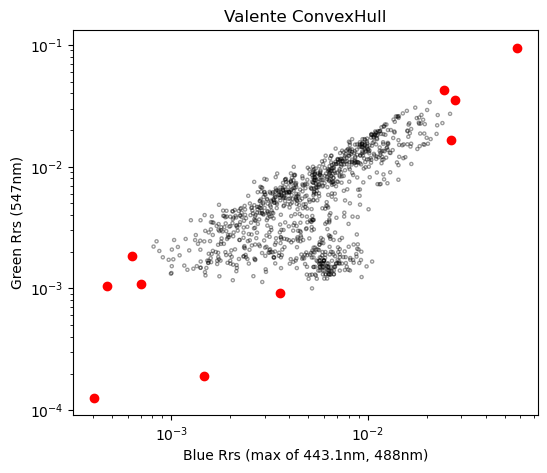

In [17]:
skip_num = 1
fig, ax = plt.subplots(figsize=(6,5))

# hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
#                        modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
#            y = modis_global.Rrs_555.values.flatten()[::skip_num],
#           yscale='log',xscale='log',
#          gridsize=30,
#           bins='log',
#          cmap='Blues')
# fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0),
           y = valente_df[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

# for simplex in hull.simplices:
#     ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')


ax.scatter(pts[dist_ratio>.2][:,0], pts[dist_ratio>.2][:,1],c='red')
# ax.scatter(np.nanmax([pts[dist_ratio>.3][:,0], pts[dist_ratio>.3][:,1]],axis=0),pts[dist_ratio>.3][:,2],c='red')

# ax.set_ylim(0.00015,0.07)
# ax.set_xlim(0.00015,0.07)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')
ax.set_title('Valente ConvexHull')

# plt.savefig('figs/modis_winter_valente_density.png',dpi=600)

plt.show()

## Pull in PACE data via earth data access

In [18]:
auth = earthaccess.login(persist=True)

In [24]:
tspan = ("2024-05-05", "2025-05-05")
# tspan = ("2018-02-20", "2019-02-20")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    # short_name="MODISA_L3m_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)
len(results)

942

In [28]:
id_list = []
for i in range(len(results)):
    # if 'L3m.8D.RRS.V3_0.Rrs.0p1deg' in results[i]['meta']['native-id']:
    if 'L3m.DAY.RRS.V3_1.Rrs.0p1deg' in results[i]['meta']['native-id']:
        id_list.append(i)
len(id_list)

356

### now check if the points from PACE are within the Hull

This is applied to a full year of data and thus takes a long time

In [29]:
from scipy.spatial import Delaunay

native_ids = [] 
datetimes = []
inside = []
outside = []
valid_pixel_count = []

count_map = np.zeros([1800,3600])
nonnan_map = np.zeros([1800,3600])

count_map_ndims = []
nonnan_map_ndims = []

step_count = 0

pts = np.array([valente_df[442.1],valente_df[490.0],valente_df[551.1]])
pts = pts.T[(~np.isnan(pts)).all(axis=0)]

hull =  Delaunay(pts[dist_ratio < 0.2])

for i in id_list:
    native_ids.append(results[i]['meta']['native-id'])
    datetimes.append(pd.to_datetime(results[i]['meta']['native-id'].split('.')[1][:8]))
    
    # paths = earthaccess.open([results[i]])
    # ds = xr.open_mfdataset(paths)

    paths = earthaccess.download(results[i], local_path="data_tmp")
    print('file downloaded')
    ds = xr.open_dataset(paths[0])
    
    # pace_pts = np.array([np.max([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten()],axis=0),ds.Rrs[:,:,84].values.flatten()]).T
    pace_pts = np.array([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten(),ds.Rrs[:,:,84].values.flatten()]).T
    
    # pace_pts = np.array([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten(),ds.Rrs[:,:,84].values.flatten()]).T
    print('data formatted')

    bool_mask = (~np.isnan(pace_pts)).all(axis=1)
    
    valid_pixel_count.append(np.count_nonzero(bool_mask))

    points_in_hull = np.zeros(6480000, dtype=bool)
    points_in_hull[bool_mask] = hull.find_simplex(pace_pts[bool_mask])>=0
    print('hull analysis done')
    
    count_map += points_in_hull.reshape(ds.Rrs.shape[:2])
    count_map_ndims.append(points_in_hull.reshape(ds.Rrs.shape[:2]))
    nonnan_map_ndims.append((~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2]))

    nonnan_map += (~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2])

    boolie, count = np.unique(points_in_hull[(~np.isnan(pace_pts)).all(axis=1)],return_counts=True)
    if boolie[0]:
        in_count = count[0]
        out_count = count[1]
    else:
        in_count = count[1]
        out_count = count[0]
    inside.append(in_count)
    outside.append(out_count)

    os.remove(paths[0])
    
    step_count  += 1
    # if step_count > 3:
    #     break
    print(step_count)

file downloaded
data formatted
hull analysis done
1
file downloaded
data formatted
hull analysis done
2
file downloaded
data formatted
hull analysis done
3
file downloaded
data formatted
hull analysis done
4
file downloaded
data formatted
hull analysis done
5
file downloaded
data formatted
hull analysis done
6
file downloaded
data formatted
hull analysis done
7
file downloaded
data formatted
hull analysis done
8
file downloaded
data formatted
hull analysis done
9
file downloaded
data formatted
hull analysis done
10
file downloaded
data formatted
hull analysis done
11
file downloaded
data formatted
hull analysis done
12
file downloaded
data formatted
hull analysis done
13
file downloaded
data formatted
hull analysis done
14
file downloaded
data formatted
hull analysis done
15
file downloaded
data formatted
hull analysis done
16
file downloaded
data formatted
hull analysis done
17
file downloaded
data formatted
hull analysis done
18
file downloaded
data formatted
hull analysis done
19
fi

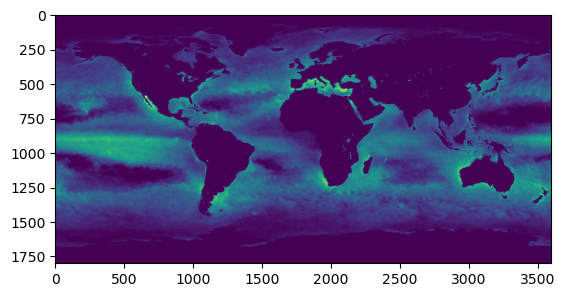

In [31]:
cb = plt.imshow(count_map)

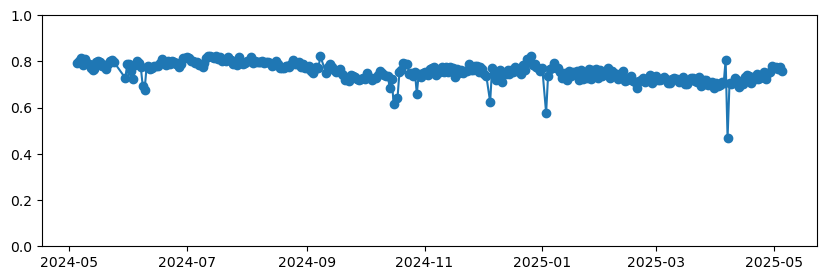

In [32]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(datetimes, np.array(inside)/np.array(valid_pixel_count),marker='o')

ax.set_ylim(0,1)
plt.show()

In [33]:
# count_map[count_map == 0] = np.nan

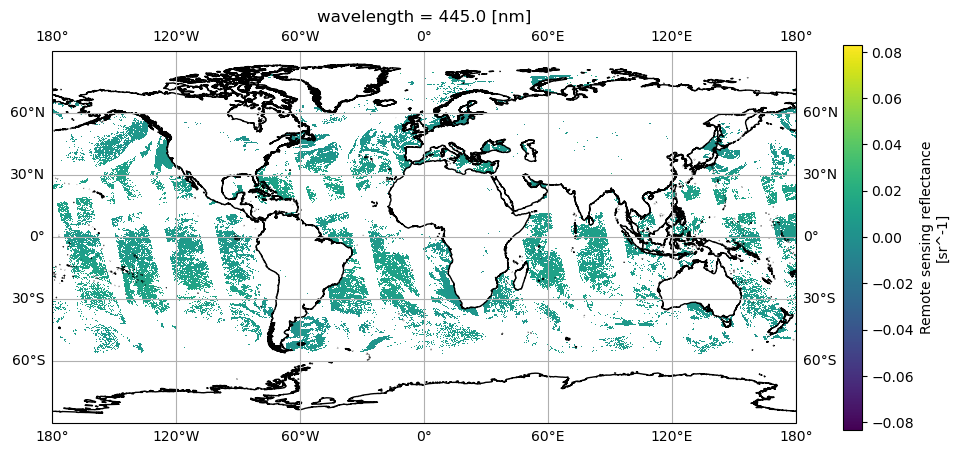

In [34]:
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

ds.Rrs[:,:,40].plot(ax=ax, x='lon', y='lat', cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

/tmp/ipykernel_151/3377128919.py:3: RuntimeWarning: invalid value encountered in divide
  cbar = plt.imshow(count_map/nonnan_map)


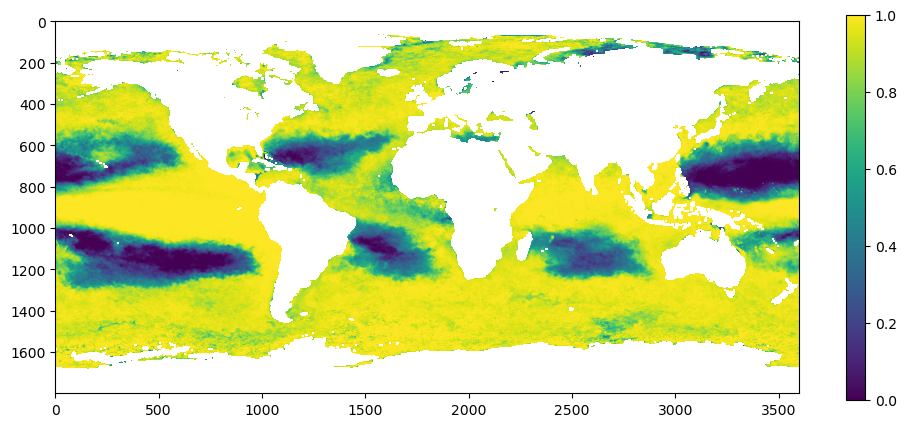

In [36]:
fig, ax = plt.subplots(figsize=(12,5))

cbar = plt.imshow(count_map/nonnan_map)
plt.colorbar(cbar)

In [37]:
ds['ones'] = (('lat', 'lon'), np.ones(ds.Rrs.shape[:-1]))

In [38]:
ds['count_map_normalized'] = (('lat', 'lon'), count_map/nonnan_map)

/tmp/ipykernel_151/1700129919.py:1: RuntimeWarning: invalid value encountered in divide
  ds['count_map_normalized'] = (('lat', 'lon'), count_map/nonnan_map)


<Axes: ylabel='Proportion'>

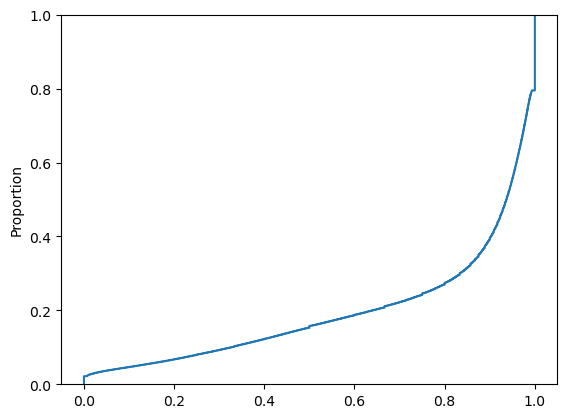

In [39]:
# plt.hist((ds['count_map_normalized'].values.flatten()))
sns.ecdfplot((ds['count_map_normalized'].values.flatten()))

<Axes: ylabel='Proportion'>

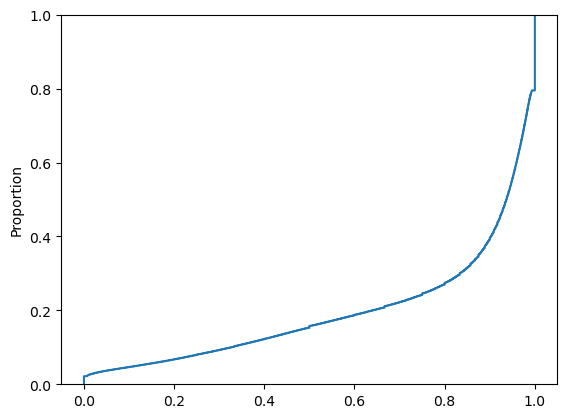

In [40]:
# plt.hist((ds['count_map_normalized'].values.flatten()))
sns.ecdfplot((ds['count_map_normalized'].values.flatten()))

In [41]:
1-np.nanmean(ds['count_map_normalized'].values.flatten())

0.19354547468906835

In [43]:
# at two bands this was 0.1186 and at 3 bands it was 0.1935
1-np.nanmean(ds['count_map_normalized'].values.flatten())

0.11865671286285173

In [44]:
ds['nonnan_map'] = (('lat', 'lon'), nonnan_map)

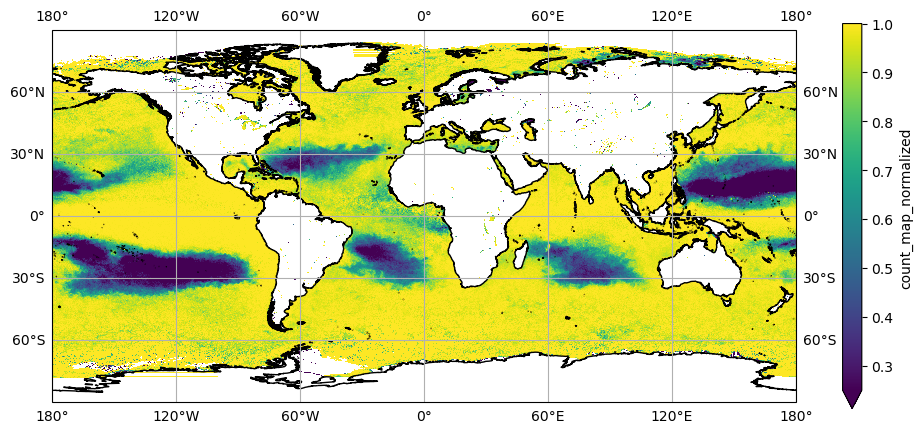

In [45]:
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.25,vmax=1)

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [46]:
cm = plt.get_cmap("viridis")
cm.set_bad("red", alpha=0)

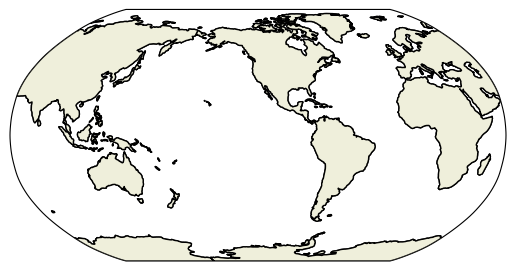

In [42]:
import cartopy as cart

ax = plt.axes(projection=crs.Robinson(central_longitude=-120))
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')

In [50]:
! pip install cmocean

  Using cached cmocean-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached cmocean-4.0.3-py3-none-any.whl (421 kB)


In [ ]:
import cmocean

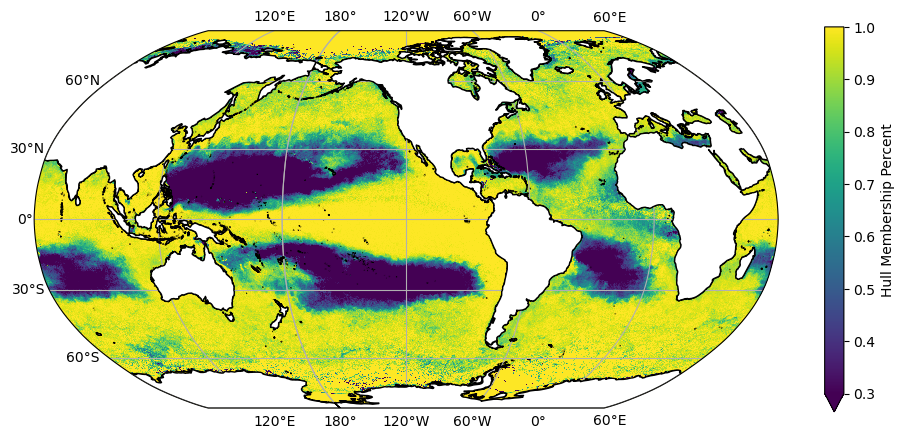

In [44]:
subplot_kws = dict(projection=crs.Robinson(central_longitude=-120), facecolor='white')
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=subplot_kws)
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.3,vmax=1, transform=crs.PlateCarree(), cbar_kwargs={'label': "Hull Membership Percent"})
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k', facecolor='white')

gl = ax.gridlines(draw_labels=True)

plt.savefig('global_pace_inhull_3d.png',dpi=300)

plt.show()

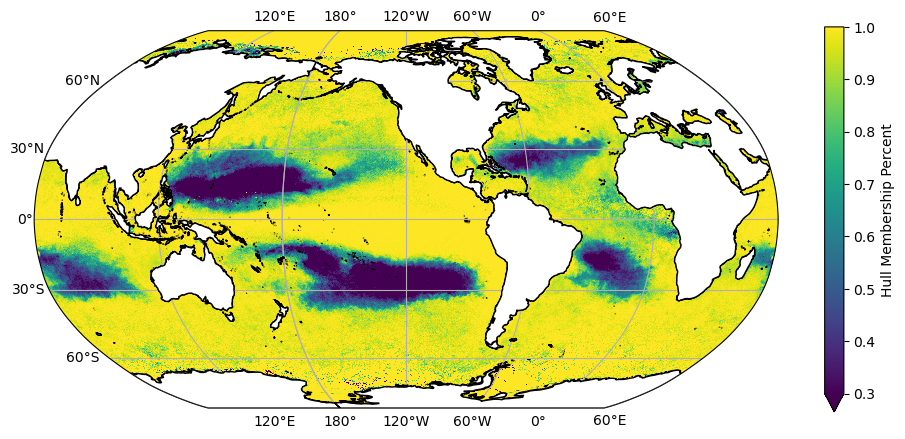

In [48]:
subplot_kws = dict(projection=crs.Robinson(central_longitude=-120), facecolor='white')
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=subplot_kws)
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.3,vmax=1, transform=crs.PlateCarree(), cbar_kwargs={'label': "Hull Membership Percent"})
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k', facecolor='white')

gl = ax.gridlines(draw_labels=True)

plt.savefig('global_pace_inhull.png',dpi=300)

plt.show()

## open the biomes files

In [45]:
biomes = xr.open_dataset('data/Time_Varying_Biomes.nc')

In [48]:
biomes_interp = biomes.MeanBiomes.interp(lon=ds.lon, lat=ds.lat)

1


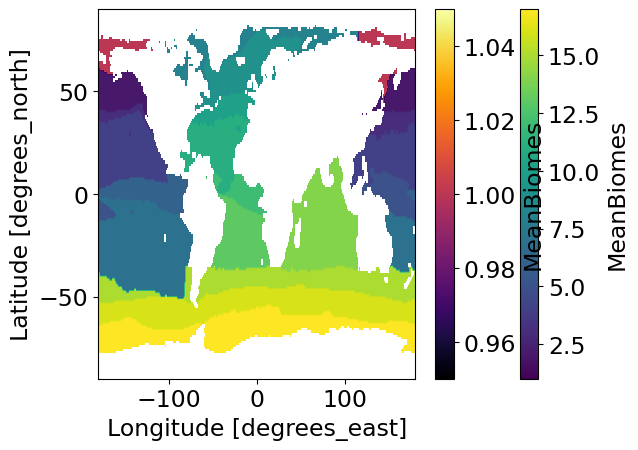

2


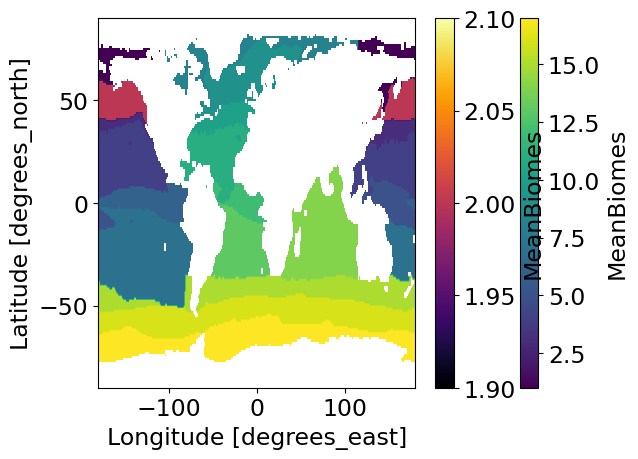

3


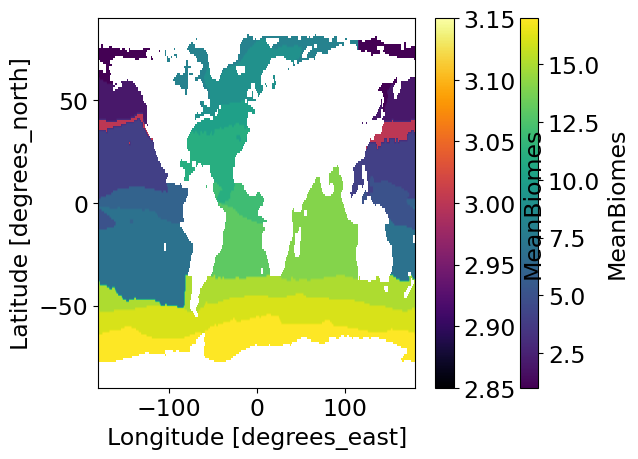

4


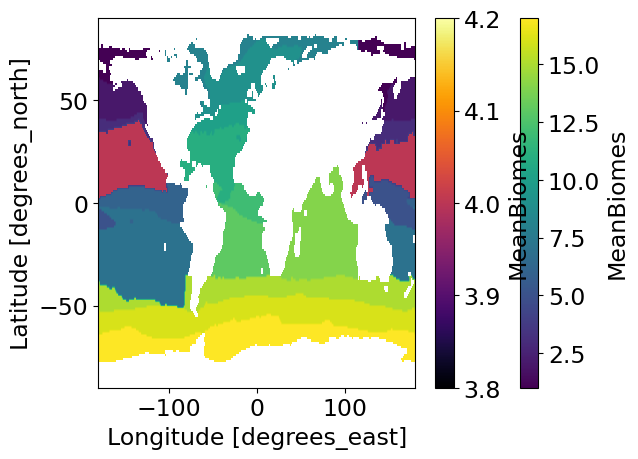

5


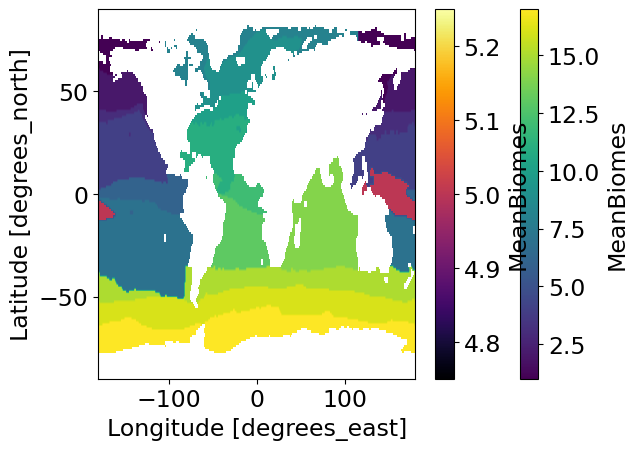

6


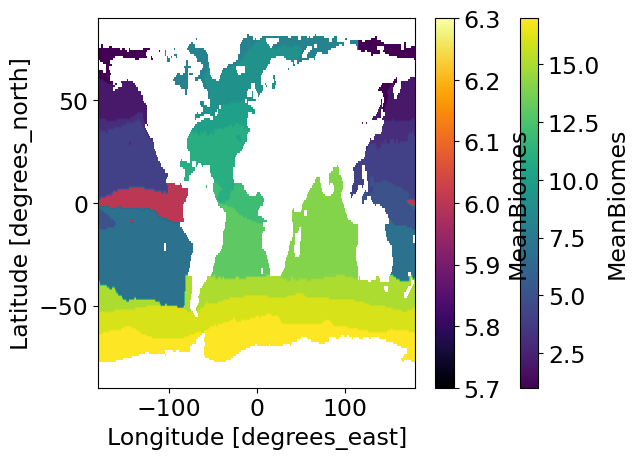

7


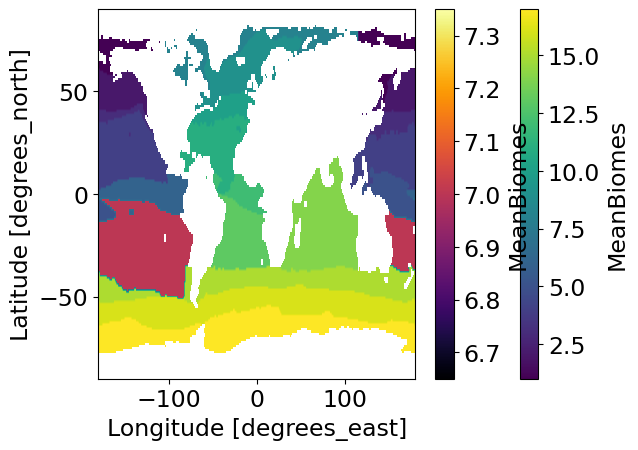

8


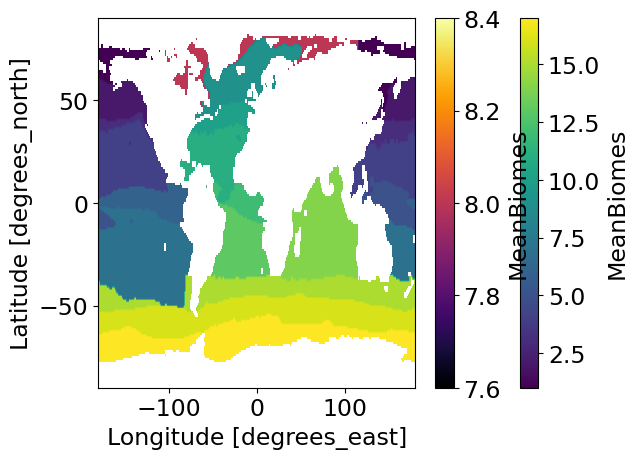

9


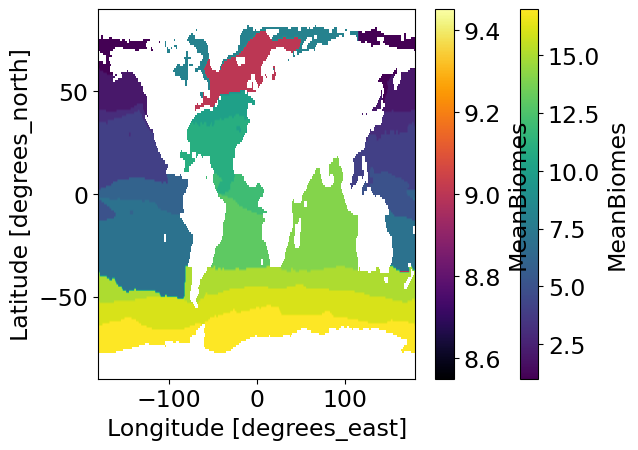

10


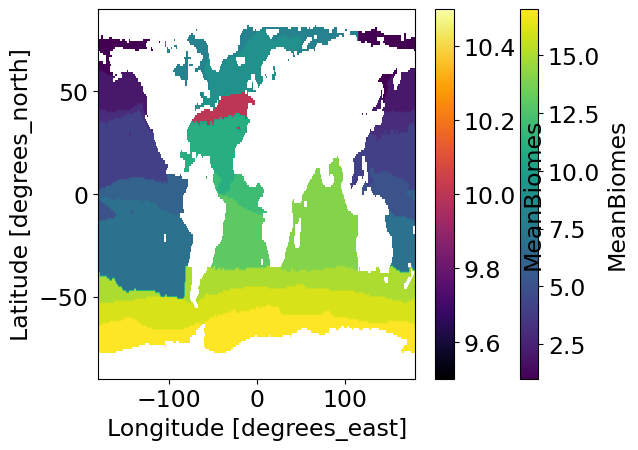

11


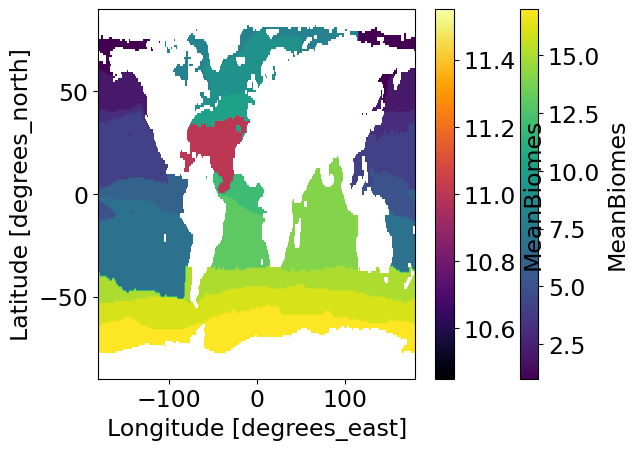

12


In [ ]:
for j in range(1,18):
    print(j)
    biomes_interp.plot(x='lon',y='lat')
    biomes_interp.where(biomes_interp==j).plot(x='lon',y='lat',cmap='inferno')
    plt.show()

In [49]:
cm = plt.get_cmap("tab20")
cm.set_bad("red", alpha=0)

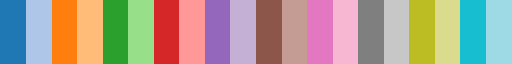

In [50]:
cm

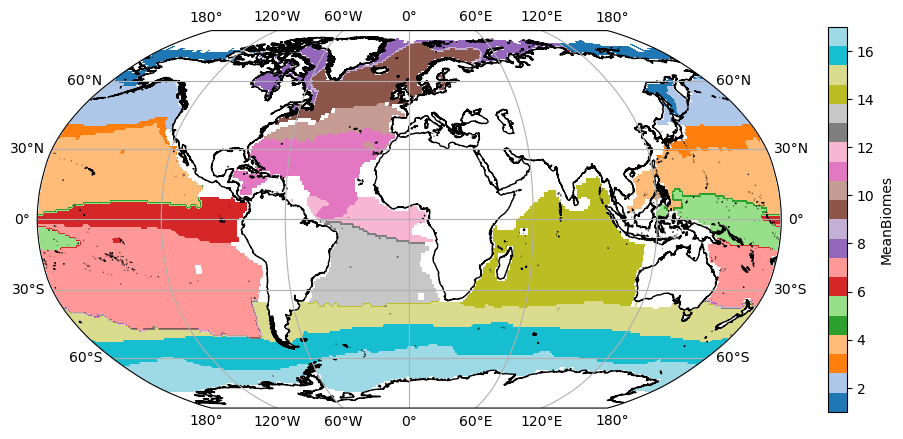

In [76]:
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')

biomes_interp.plot(ax=ax, x='lon',y='lat',cmap=cm, transform=crs.PlateCarree())
gl = ax.gridlines(draw_labels=True)

# ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k', facecolor='white')

plt.savefig('ocean_biomes.png',dpi=300)

plt.show()

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
plt.rcParams.update({'font.size': 17})

1


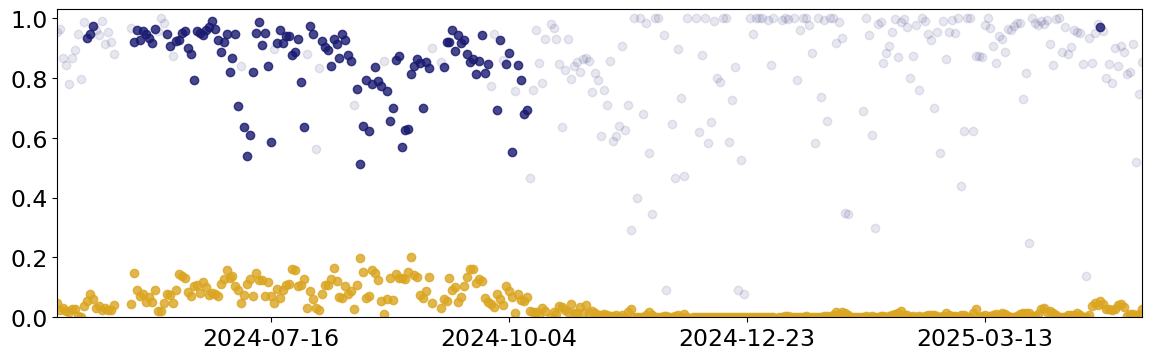

2


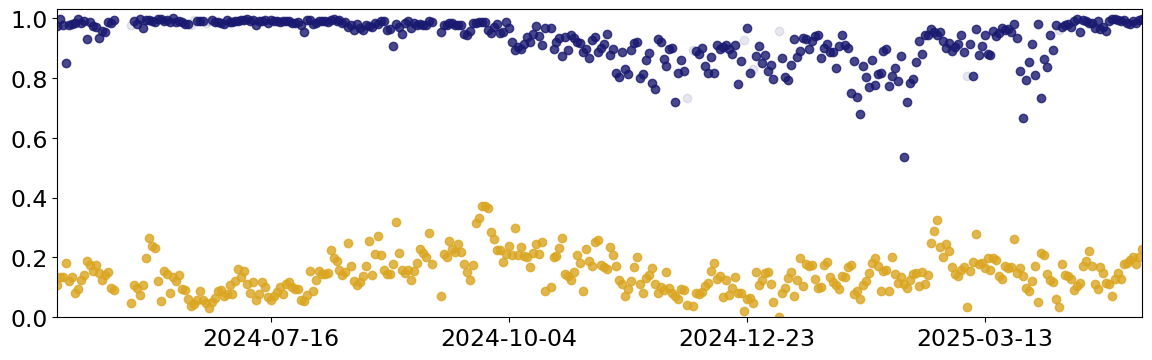

3


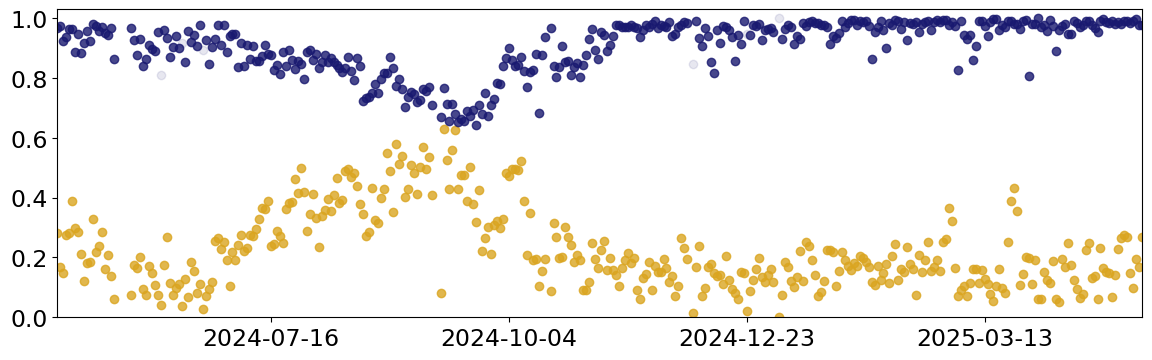

4


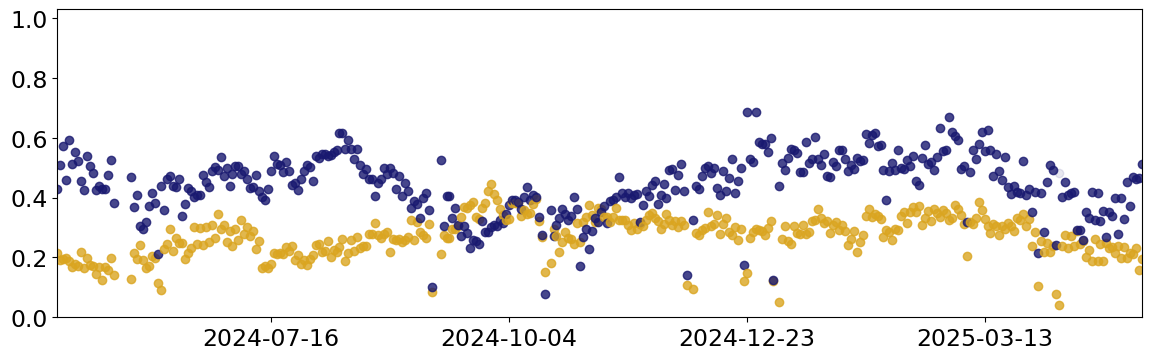

5


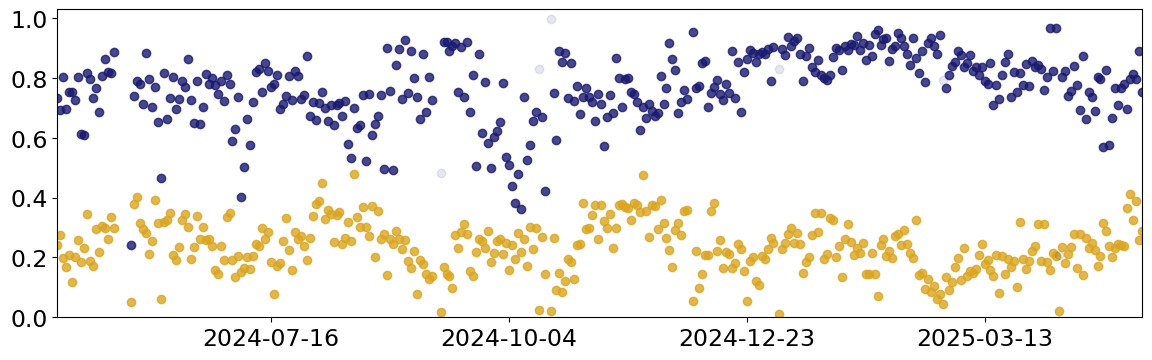

6


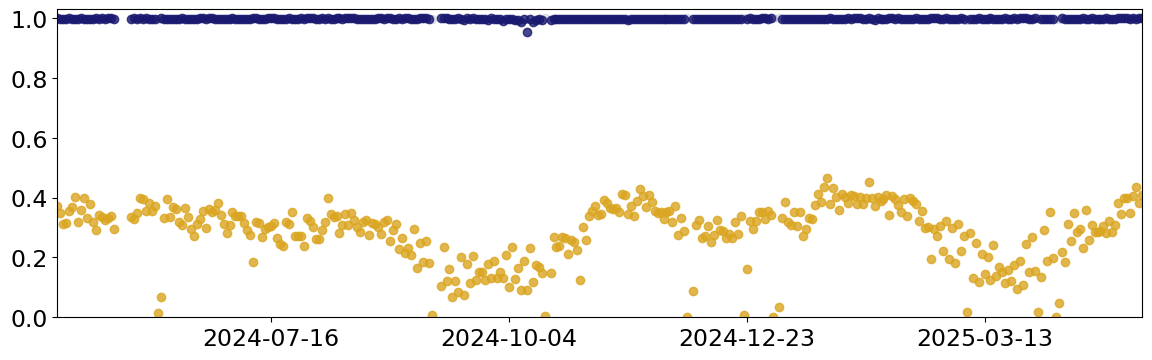

7


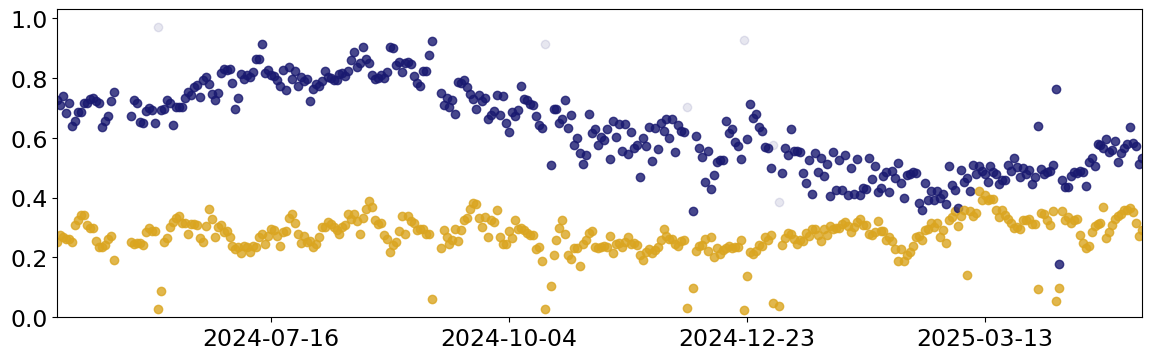

8


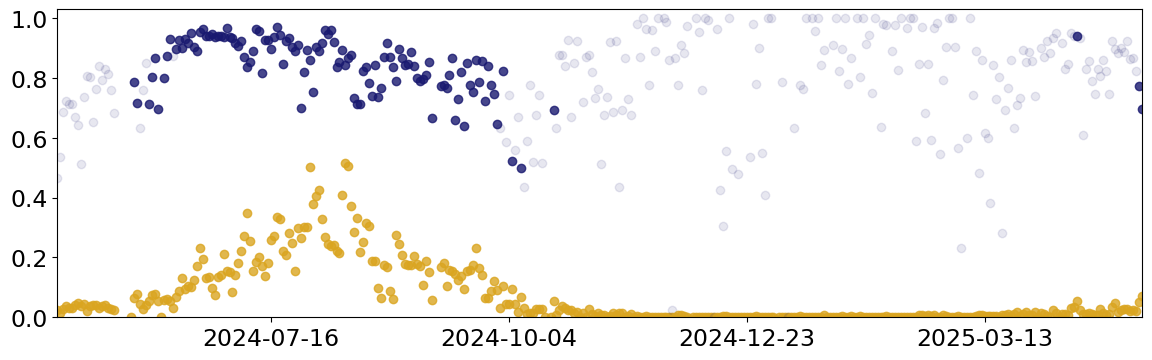

9


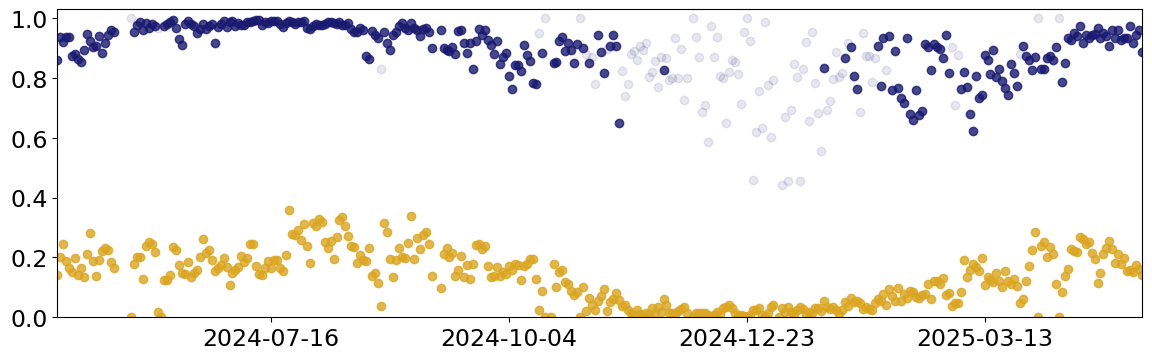

10


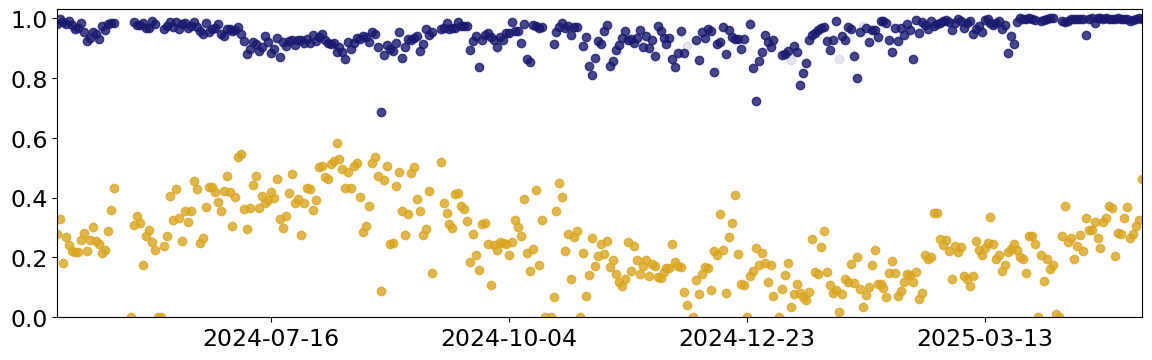

11


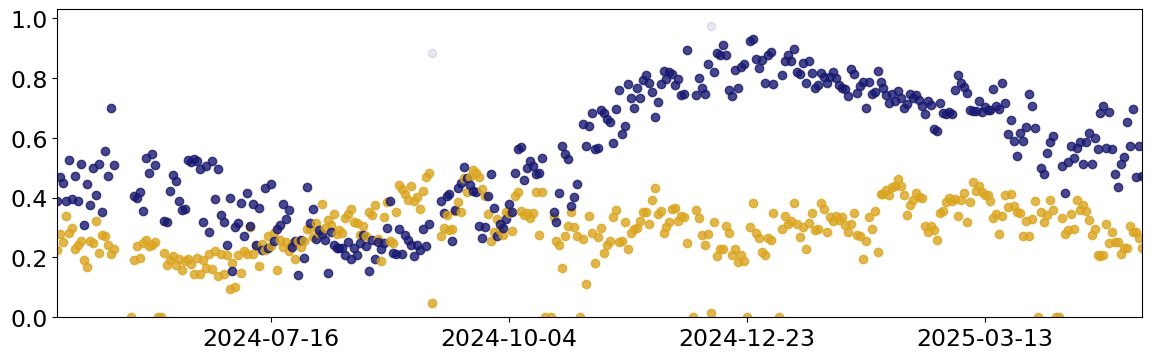

12


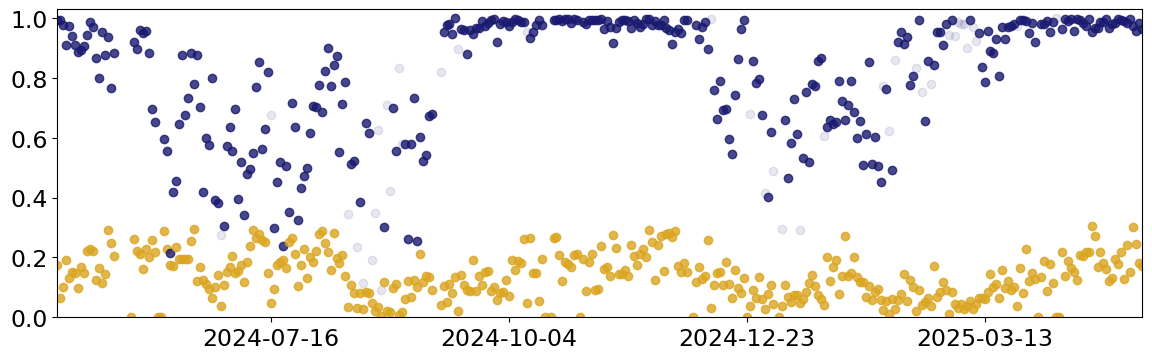

13


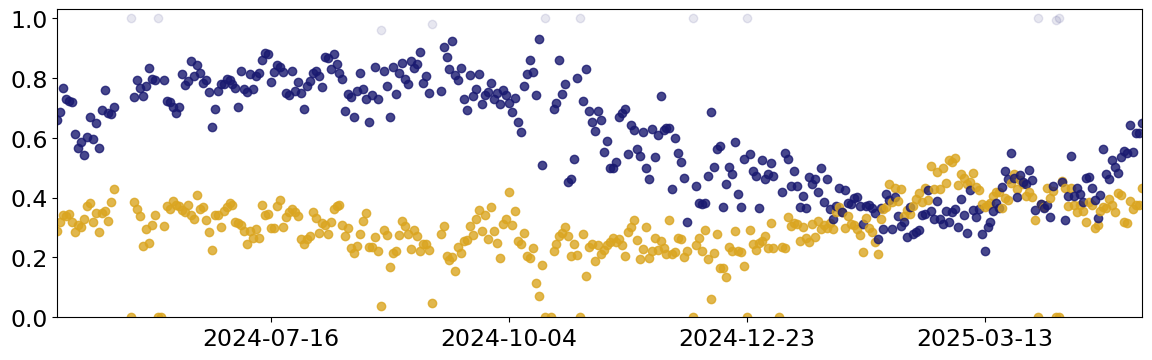

14


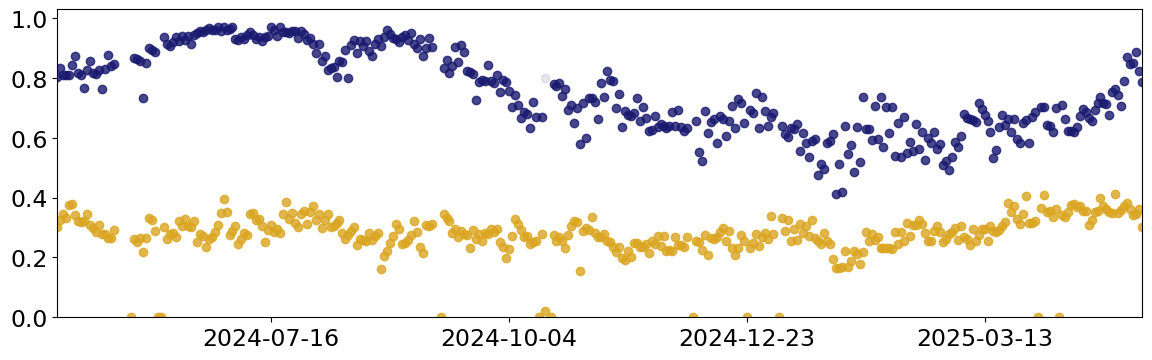

15


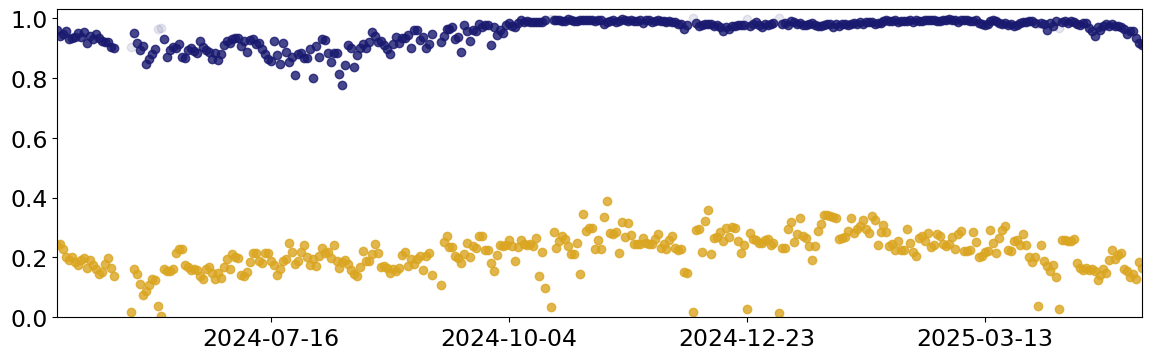

16


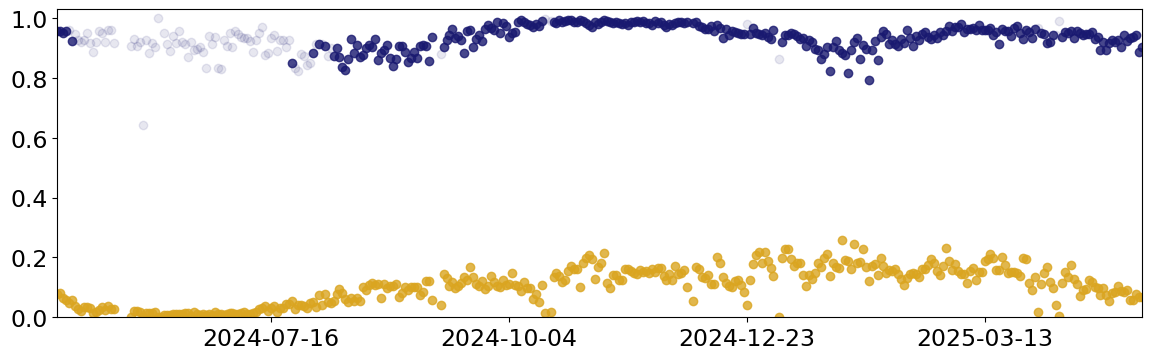

17


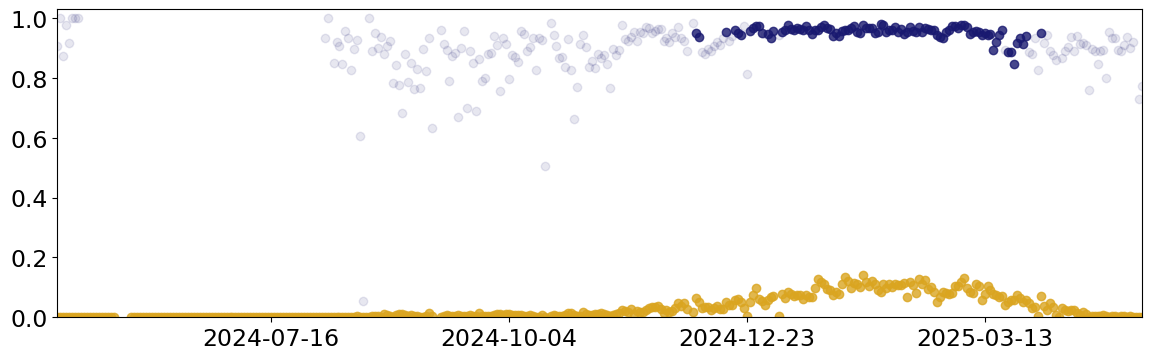

In [53]:
for j in range(1,18):
    print(j)
    # biomes_interp.plot(x='lon',y='lat')
    # biomes_interp.where(biomes_interp==j).plot(x='lon',y='lat',cmap='inferno')
    # plt.show()
    
    fig, ax = plt.subplots(figsize=(14,4))
    # ax2 = ax.twinx()
    
    for i in range(len(count_map_ndims)):
        col = 'k'
        ds['counts'] = (('lat', 'lon'), np.array(nonnan_map_ndims[i]))
        # print(ds.counts.where(biomes_interp==j).sum())
        # if ds.counts.where(biomes_interp==j).sum() < 5000:
        #     print('under 5000 pixels')
        #     continue
        non_nan_sum = ds.counts.where(biomes_interp==j).sum()
        percent_available = non_nan_sum/ds.ones.where(biomes_interp==j).sum()
        ax.scatter(datetimes[i], percent_available,c='goldenrod',alpha=.8)
        # if there are less than 5% of the pixels in a region or less than 1000 pixels let's flag it
        alpha=.8
        if percent_available < 0.05:
            col = 'red'
            alpha = .1
        if non_nan_sum < 1000:
            col = 'red'
            alpha = .1
        ds['counts'] = (('lat', 'lon'), np.array(count_map_ndims[i])/np.array(nonnan_map_ndims[i]))
        # ds.counts.where(biomes_interp==4).plot(x='lon',y='lat')
    
        ax.scatter(datetimes[i], ds.counts.where(biomes_interp==j).mean(),alpha=alpha,c='midnightblue')
    
    ax.set_xlim(datetimes[0],datetimes[-1])
    ax.set_ylim(0,1.03)
    # ax2.set_ylim(0,1.03)

    # ax.yaxis.label.set_color('black')
    # ax.tick_params(axis='y', colors='black')
    
    # ax2.yaxis.label.set_color('blue')
    # ax2.tick_params(axis='y', colors='blue')

    ax.xaxis.set_major_locator(plt.MaxNLocator(6))

    plt.savefig('figs/rhythm_biome_3d'+str(j)+'.png',dpi=300)

    plt.show()
    print('========================================================================================')